In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
# Load dataset paths and labels
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

train_df.tail()

Training samples: 275
Validation samples: 70


,image:FILE,category
270,train/dog/scottish_terrier_128_jpg.rf.cb2c8f24...,1
271,train/dog/samoyed_149_jpg.rf.c6bf305eaa640bc12...,1
272,train/dog/english_setter_172_jpg.rf.cb3f08fd8d...,1
273,train/dog/shiba_inu_135_jpg.rf.ca95dbdfbdf5b08...,1
274,train/dog/wheaten_terrier_141_jpg.rf.ce5fe30e4...,1


In [3]:
import numpy as np
import cv2
import os

def load_and_preprocess_images(df, img_size=(64, 64)):
    images = []
    labels = []
    for idx, row in df.iterrows():
        img_path = row['image:FILE']
        label = row['category']
        
        # Check if file exists
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        
        # Resize image
        img = cv2.resize(img, img_size)
        
        images.append(img)
        labels.append(label)
        
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Set image size
IMAGE_SIZE = (264, 264)

# Load training images
X_train, y_train = load_and_preprocess_images(train_df, img_size=IMAGE_SIZE)

# Load validation images
X_val, y_val = load_and_preprocess_images(val_df, img_size=IMAGE_SIZE)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (275, 264, 264, 3)
Validation data shape: (70, 264, 264, 3)


In [4]:
# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

In [5]:
# Flatten images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened validation data shape: {X_val_flat.shape}")

Flattened training data shape: (275, 209088)
Flattened validation data shape: (70, 209088)


In [6]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both training and validation data
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)

In [7]:
from sklearn.svm import SVC

# Initialize SVM classifier
svm_classifier = SVC(kernel='poly', C=1,gamma='scale', random_state=42)

# Train the classifier
svm_classifier.fit(X_train_scaled, y_train)

SVC(C=1, kernel='poly', random_state=42)

Validation Accuracy: 0.6714
Classification Report:
               precision    recall  f1-score   support

         Cat       1.00      0.04      0.08        24
         Dog       0.67      1.00      0.80        46

    accuracy                           0.67        70
   macro avg       0.83      0.52      0.44        70
weighted avg       0.78      0.67      0.55        70



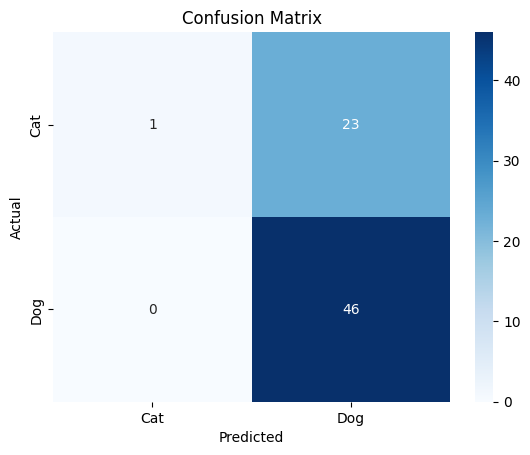

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on validation set
y_val_pred = svm_classifier.predict(X_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Classification report
report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [ 0.1, 1, 10 ],
    'kernel': ['linear', 'rbf' , 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Initialize Grid Search
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit to training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  20.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  21.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  21.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  21.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  21.4s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   4.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   4.4s
[CV] END ...................

In [10]:
# Predict with best estimator
best_svm = grid_search.best_estimator_
y_val_pred_best = best_svm.predict(X_val_scaled)

# Calculate accuracy
best_accuracy = accuracy_score(y_val, y_val_pred_best)
print(f"Tuned Validation Accuracy: {best_accuracy:.4f}")

# Classification report
best_report = classification_report(y_val, y_val_pred_best, target_names=['Cat', 'Dog'])
print("Tuned Classification Report:\n", best_report)

Tuned Validation Accuracy: 0.6429
Tuned Classification Report:
               precision    recall  f1-score   support

         Cat       0.00      0.00      0.00        24
         Dog       0.65      0.98      0.78        46

    accuracy                           0.64        70
   macro avg       0.33      0.49      0.39        70
weighted avg       0.43      0.64      0.51        70



HOG feature extraction

In [11]:
from skimage.color import rgb2gray
from skimage.feature import hog

def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Convert the image to grayscale
        gray_img = rgb2gray(img)  # Convert to 2D (grayscale)
        
        # Extract HOG features
        feature = hog(
            gray_img, 
            orientations=9, 
            pixels_per_cell=(8, 8), 
            cells_per_block=(2, 2), 
            block_norm='L2-Hys',
            visualize=False
        )
        
        hog_features.append(feature)
    
    return np.array(hog_features)

# Example of using the function on your training data
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)


svm_classifier = SVC(kernel='poly', C=0.1, gamma='scale', random_state=42)

# Train SVM with HOG features
svm_classifier.fit(X_train_hog, y_train)

SVC(C=0.1, kernel='poly', random_state=42)

In [12]:
from sklearn.metrics import accuracy_score

# Make predictions
y_pred = svm_classifier.predict(X_val_hog)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 67.14%


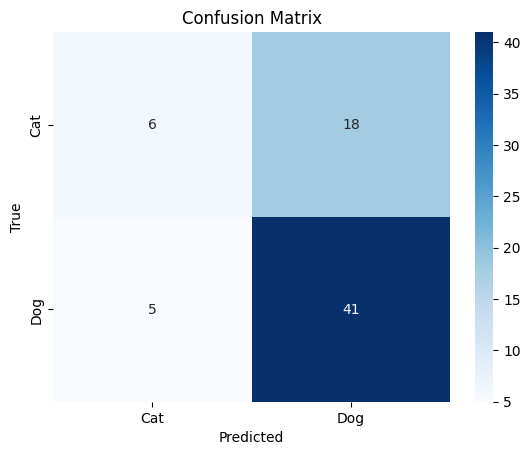

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

VGG16 feature extraction

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.image import resize

# Step 1: Resize the images to (224, 224, 3)
X_train_resized = tf.image.resize(X_train, (224, 224))
X_val_resized = tf.image.resize(X_val, (224, 224))

# Step 2: Preprocess the resized images for VGG16
X_train_preprocessed = preprocess_input(X_train_resized)
X_val_preprocessed = preprocess_input(X_val_resized)

# Step 3: Load VGG16 pretrained on ImageNet
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 4: Extract features using the VGG16 model
X_train_vgg = vgg_model.predict(X_train_preprocessed)
X_val_vgg = vgg_model.predict(X_val_preprocessed)

# Step 5: Flatten the extracted features
X_train_vgg_flat = X_train_vgg.reshape(X_train_vgg.shape[0], -1)
X_val_vgg_flat = X_val_vgg.reshape(X_val_vgg.shape[0], -1)

# Step 6: Train SVM using the extracted and flattened features
svm_classifier.fit(X_train_vgg_flat, y_train)

3/3 [==============================] - 7s 2s/step


SVC(C=0.1, kernel='poly', random_state=42)

In [15]:
from sklearn.metrics import accuracy_score

# Make predictions on the validation set
y_pred = svm_classifier.predict(X_val_vgg_flat)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 65.71%
